In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd
import cv2
import glob
import gdcm
import pydicom

from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, Dense, Flatten
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.metrics import binary_accuracy, AUC
from sklearn.model_selection import train_test_split
from keras.layers import Add, Activation, ZeroPadding2D, BatchNormalization, Concatenate, AveragePooling2D, MaxPool2D, Reshape, Conv2DTranspose

In [7]:
train_images = glob.glob('./dataset/images/*.png')
test_images = glob.glob('./dataset/test/*.png')

len(train_images), len(test_images)

(670, 65)

In [33]:
img = imread(train_images[2])

In [34]:
img.shape

(256, 320, 4)

In [24]:
cv2.resize(img,(256,256)).shape

(256, 256, 4)

In [ ]:
for f in tqdm(train_images[:3]):
    image = f.split('/')[-1][:-4]
    img = imread(f)

    img = (img - img.min()) / (img.max() - img.min())

    img = cv2.resize(img, (256,256))
        
    plt.figure(figsize=(5, 5))
    plt.imshow(img, cmap="gray")
    plt.title(f"{image}")
    plt.show()

In [25]:
def decode_rle(rle_str, img_shape):
    """
    This function decodes a string of run-length encoded (RLE) pixel data into
    a binary mask.
    """
    mask = np.zeros(img_shape[0]*img_shape[1], dtype=np.uint8)
    pairs = rle_str.split(' ')
    for i in range(0, len(pairs), 2):
        start = int(pairs[i]) - 1  # RLE coordinates are 1-indexed
        length = int(pairs[i+1])
        end = start + length
        mask[start:end] = 1
    mask = mask.reshape(img_shape[0], img_shape[1])
    return mask

In [26]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 4
TRAIN_PATH = './dataset/images/'
TEST_PATH = './dataset/test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

# Get the file names of all the images in the folder
image_names = os.listdir(TRAIN_PATH)

# Split the images into a training set and a testing set
train_names, val_names = train_test_split(image_names, test_size=0.1, random_state=42)

In [20]:
train_names[3]

'0b2e702f90aee4fff2bc6e4326308d50cf04701082e718d4f831c8959fbcda93.png'

In [36]:
csv_path = './data/stage1_train_labels.csv'
df = pd.read_csv(csv_path)

# Get the patient IDs, image IDs, and labels from the CSV file
image_ids = df['ImageId'].values
labels = df.drop('ImageId', axis=1).values

image_id = train_names[3][:-4]

index = np.where(image_ids == image_id)

In [42]:
for i in index[0]:
    print(i)

1325
1326
1327
1328
1329


In [ ]:
csv_path = './data/stage1_train_labels.csv'

# Read the CSV file
df = pd.read_csv(csv_path)

# Get the patient IDs, image IDs, and labels from the CSV file
image_ids = df['ImageId'].values
labels = df.drop('ImageId', axis=1).values

# Get and resize train images and masks
X_train = np.zeros((len(train_names), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_names), IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_names), total=len(train_names)):
    path = TRAIN_PATH + '/' + id_
    img = imread(path)
    X_train[n] = img
    
    image_id = id_[:-4]
    index = np.where(image_ids == image_id)

    for i in index[0]:
        
    
    if len(index) > 0:
        # Get the label from the CSV file
        label = labels[index[0]]

        # Add the label to the labels list
        Y_box_train = np.append(Y_box_train, label[0][0:4])
        Y_ds_train = np.append(Y_ds_train, label[0][4])

print('Done!')

U-NET


In [4]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

In [5]:
# The convolation block 
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    return x


# The encoder block
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    
    return x, p


# The decoder block
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)

    return x

In [6]:
def unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    modelUnet = Model(inputs=inputs, outputs=outputs, name="OriginalUNET")

    modelUnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return modelUnet

In [9]:
trainPath = "./data/stage1_train/"
testPath = "./data/stage1_test/"
test2Path = "./data/stage2_test_final/"

In [10]:
train_ids = next(os.walk(trainPath))[1]
test_ids = next(os.walk(testPath))[1]
test2_ids = next(os.walk(test2Path))[1]

In [11]:
X_train = np.zeros((len(train_ids), 128, 128, 3), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), 128, 128, 1), dtype=np.bool_)

In [50]:
print("Resizing training images and masks")
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = trainPath + id_
    img = imread(path + "/images/" + id_ + ".png")[:, :, :3]
    img = resize(img, (128, 128), mode="constant", preserve_range=True)
    X_train[n] = img
    mask = np.zeros((128, 128, 1), dtype=np.bool_)
    for mask_file in next(os.walk(path+"/masks/"))[2]:
        mask_ = imread(path+"/masks/"+mask_file)
        mask_ = np.expand_dims(resize(mask_, (128, 128), mode="constant", preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)

    Y_train[n] = mask

Resizing training images and masks


  0%|          | 0/670 [00:00<?, ?it/s]

In [69]:
X_test = np.zeros((len(test_ids), 128, 128, 3), dtype=np.uint8)
sizes_test = []

print("Resizing test images")
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = testPath + id_
    img = imread(path + "/images/" + id_ + ".png")[:,:,:3]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (128, 128), mode = "constant", preserve_range=True)
    X_test[n] = img

Resizing test images


  0%|          | 0/65 [00:00<?, ?it/s]

In [12]:
import imagecodecs

In [20]:
X_test2 = np.zeros((len(test2_ids), 128, 128, 3), dtype=np.uint8)
sizes_test2 = []

print("Resizing test images")
for n, id_ in tqdm(enumerate(test2_ids), total=len(test2_ids)):
    path = test2Path + id_
    try:
        img = imread(path + "/images/" + id_ + ".png")[:,:,:3]
    except IndexError as ex:
        # if the image is something wrong, return 0-array
        print('Error occurred: ', n, 'th image, ', ex)
        img = np.zeros((256, 256, 3))
    sizes_test2.append([img.shape[0], img.shape[1]])
    img = resize(img, (128, 128), mode = "constant", preserve_range=True)
    X_test2[n] = img

Resizing test images


  0%|          | 0/3019 [00:00<?, ?it/s]

Error occurred:  1235 th image,  too many indices for array: array is 2-dimensional, but 3 were indexed


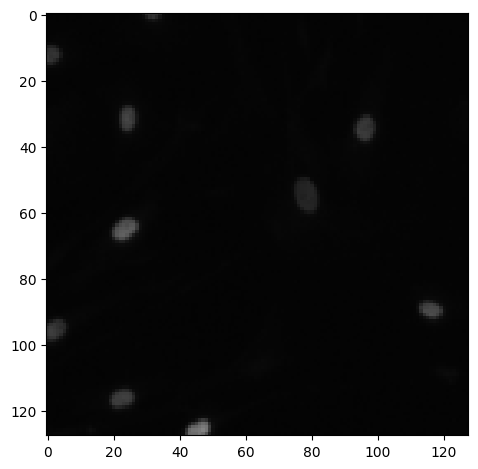

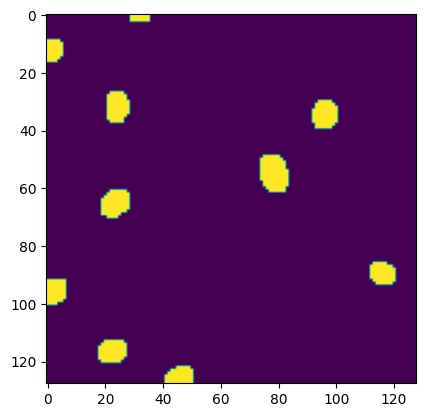

In [52]:
image_x = random.randint(0, len(train_ids))
imshow(X_train[image_x])
plt.show()
plt.imshow(np.squeeze(Y_train[image_x]))

In [55]:
modelUNet = unet((128, 128, 3))
# checkpointer = tf.keras.callbacks.ModelCheckpoint("modelUnet.h5", verbose=1, save_best_only=True)
callbacks=[
#     checkpointer,
    tf.keras.callbacks.EarlyStopping(patience=2, monitor="val_loss"),
    tf.keras.callbacks.TensorBoard(log_dir="logs")]


results = modelUNet.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)

Epoch 1/25
38/38 [==============================] - 203s 5s/step - loss: 0.2925 - accuracy: 0.8918 - val_loss: 611.9446 - val_accuracy: 0.2302
Epoch 2/25
38/38 [==============================] - 199s 5s/step - loss: 0.1753 - accuracy: 0.9370 - val_loss: 2.1224 - val_accuracy: 0.6957
Epoch 3/25
38/38 [==============================] - 194s 5s/step - loss: 0.1287 - accuracy: 0.9535 - val_loss: 0.4358 - val_accuracy: 0.8655
Epoch 4/25
38/38 [==============================] - 194s 5s/step - loss: 0.1325 - accuracy: 0.9487 - val_loss: 0.5027 - val_accuracy: 0.7475
Epoch 5/25
38/38 [==============================] - 194s 5s/step - loss: 0.1168 - accuracy: 0.9567 - val_loss: 0.3017 - val_accuracy: 0.8592
Epoch 6/25
38/38 [==============================] - 194s 5s/step - loss: 0.1392 - accuracy: 0.9467 - val_loss: 0.2496 - val_accuracy: 0.9079
Epoch 7/25
38/38 [==============================] - 195s 5s/step - loss: 0.1214 - accuracy: 0.9560 - val_loss: 0.2333 - val_accuracy: 0.9138
Epoch 8/25


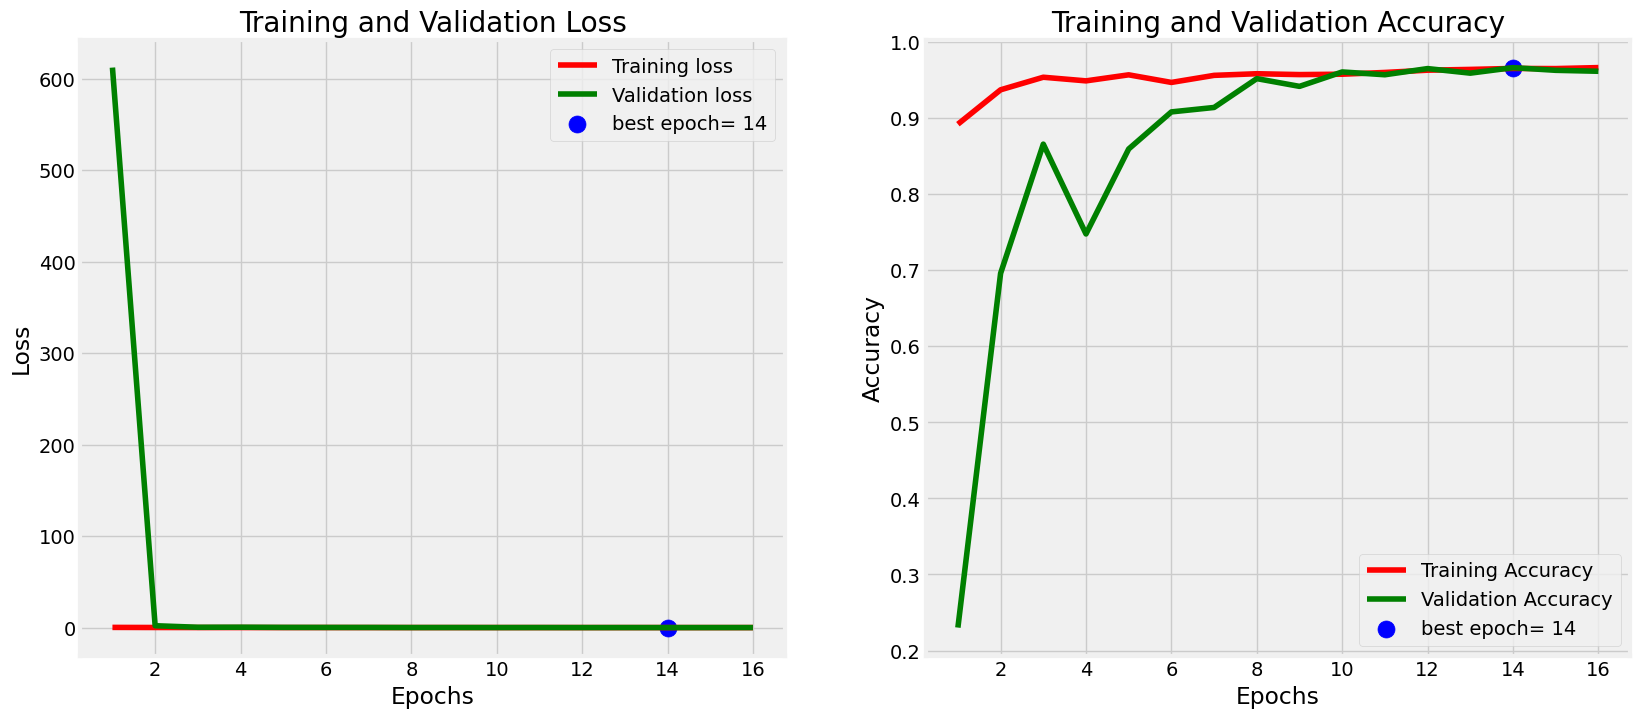

In [56]:
plot_training(results)

In [57]:
idx = random.randint(0, len(X_train))


preds_train = modelUNet.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = modelUNet.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = modelUNet.predict(X_test, verbose=1)

3/3 [==============================] - 5s 1s/step


In [58]:
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

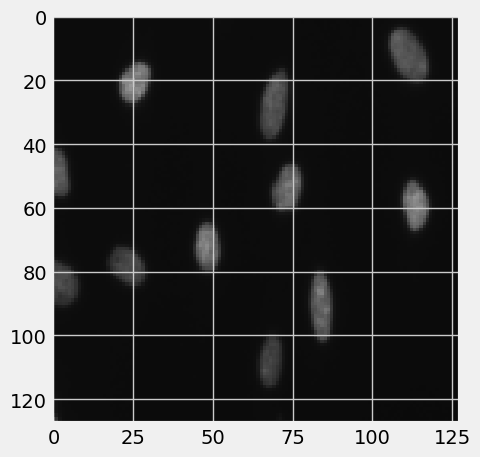

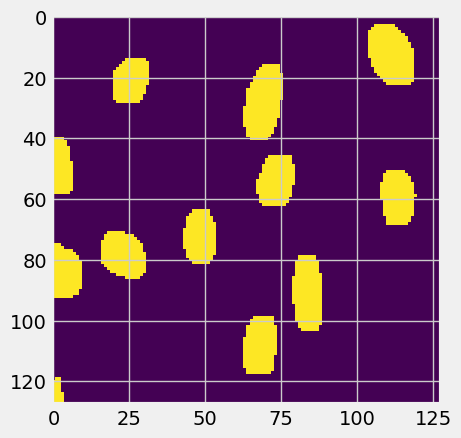

In [59]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
# plt.imshow(np.squeeze(Y_train[ix]))
plt.imshow(np.squeeze(preds_train_t[ix]))

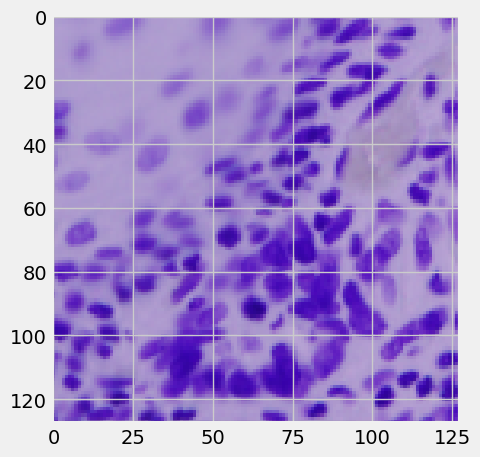

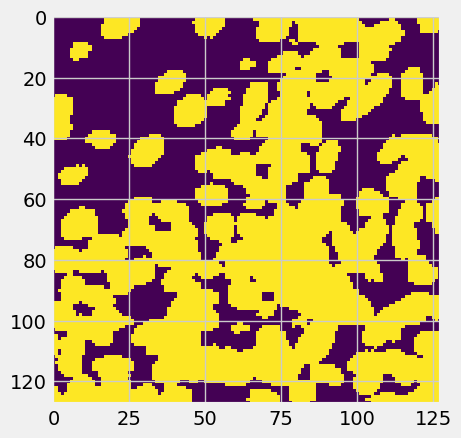

In [60]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
# plt.imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.imshow(np.squeeze(preds_val_t[ix]))

In [22]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [62]:
# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

In [63]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [64]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('submission.csv', index=False)

In [76]:
modelUNet.save('my_U-NET.h5')

In [21]:
modelUNet = load_model('my_U-NET.h5')

In [23]:
preds_test2 = modelUNet.predict(X_test2, verbose=1)


95/95 [==============================] - 219s 2s/step


NameError: name 'preds_test' is not defined

In [24]:
preds_test2_t = (preds_test2 > 0.5).astype(np.uint8)

In [25]:
# Create list of upsampled test masks
preds_test2_upsampled = []
for i in range(len(preds_test2)):
    preds_test2_upsampled.append(resize(np.squeeze(preds_test2[i]), 
                                       (sizes_test2[i][0], sizes_test2[i][1]), 
                                       mode='constant', preserve_range=True))

In [26]:
new_test2_ids = []
rles2 = []
for n, id_ in enumerate(test2_ids):
    rle = list(prob_to_rles(preds_test2_upsampled[n]))
    rles2.extend(rle)
    new_test2_ids.extend([id_] * len(rle))

In [27]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test2_ids
sub['EncodedPixels'] = pd.Series(rles2).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('submission2.csv', index=False)